In [20]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [28]:
import sys
import os
sys.path.append("../../")

import pickle
import geopandas as gpd
from pathlib import Path
import getpass
from sklearn.preprocessing import MinMaxScaler

from povertymapping.rollout_grids import get_region_filtered_bingtile_grids 
from povertymapping import settings, nightlights
from povertymapping.iso3 import get_iso3_code
from povertymapping.dhs import generate_dhs_cluster_level_data
from povertymapping.feature_engineering import generate_features, categorize_wealth_index

import numpy as np
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt

# Thailand Model Rollout Part 3 (Feature Engineering and Model Prediction on Rollout Grids)

This notebook runs the final model to create relative wealth estimations over populated areas within the given country. The model predictions will have a spatial resolution of 2.4km.

The `predicted relative wealth` value gives us the relative wealth level of an area compared to the rest of the country, which fixes the value range from 0 (lowest wealth) to 1 (highest wealth). In between these extremes, each area's wealth estimate is scaled to a value between 0 and 1.

The predicted relative wealth value is later binned into 5 wealth categories A-E by dividing the distribution into quintiles. 

## Set up Data Access
The following cell will prompt you to enter your EOG username and password. See [this page](https://eogdata.mines.edu/products/register/) to learn how to set-up your EOG account.

In [22]:
# Log-in using EOG credentials
username = os.environ.get('EOG_USER',None)
username = username if username is not None else input('Username?')
password = os.environ.get('EOG_PASSWORD',None)
password = password if password is not None else getpass.getpass('Password?') 

# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username,password, save_token=True)

2023-03-24 09:15:32.971 | INFO     | povertymapping.nightlights:get_eog_access_token:48 - Saving access_token to ~/.eog_creds/eog_access_token
2023-03-24 09:15:32.978 | INFO     | povertymapping.nightlights:get_eog_access_token:56 - Adding access token to environmentt var EOG_ACCESS_TOKEN


## Set country-specific parameters

In [23]:
country_osm = "thailand"
ookla_year = 2019
nightlights_year = 2019
country_code = get_iso3_code(country_osm, code='alpha-2').lower()
rollout_date = '-'.join(os.getcwd().split('/')[-2].split('-')[:3])
rollout_grids_path = Path(f'./{rollout_date}-{country_code}-rollout-grids.geojson')
rollout_grids_path

Path('2023-02-21-th-rollout-grids.geojson')

## Set Model Parameters

In [24]:
# Model to use for prediction
MODEL_SAVE_PATH = Path(f'../{rollout_date}-cross-country-model.pkl')

## Load Country Rollout AOI

The rollout area of interest is split into 2.4km grid tiles (zoom level 14), matching the areas used during model training. The grids are also filtered to only include populated areas based on Meta's High Resolution Settlement Layer (HRSL) data.

Refer to the previous notebook `2_th_generate_grids.ipynb` for documentation on generating this grid.

In [25]:
aoi = gpd.read_file(rollout_grids_path)
# aoi.explore() # Uncomment to view data in a map 

## Generate Features For Rollout AOI

If this is your first time running this notebook for this specific area, expect a long runtime for the following cell as it will download and cache the required datasets. It will then process the relevant features for each area specified. On subsequent runs, the runtime will be much faster as the data is already stored in your filesystem. 

In [26]:
%%time
scaler = MinMaxScaler
rollout_aoi = aoi.copy()

# Create features dataframe using generate_features module
features = generate_features(rollout_aoi, country_osm, ookla_year, nightlights_year, scaled_only=True, sklearn_scaler=scaler,features_only=True)

2023-03-24 09:15:52.398 | INFO     | povertymapping.osm:download_osm_country_data:199 - OSM Data: Cached data available for thailand at /home/jace/.geowrangler/osm/thailand? True
2023-03-24 09:15:52.400 | DEBUG    | povertymapping.osm:load_pois:161 - OSM POIs for thailand being loaded from /home/jace/.geowrangler/osm/thailand/gis_osm_pois_free_1.shp
2023-03-24 09:16:48.266 | INFO     | povertymapping.osm:download_osm_country_data:199 - OSM Data: Cached data available for thailand at /home/jace/.geowrangler/osm/thailand? True
2023-03-24 09:16:48.268 | DEBUG    | povertymapping.osm:load_roads:180 - OSM Roads for thailand being loaded from /home/jace/.geowrangler/osm/thailand/gis_osm_roads_free_1.shp
2023-03-24 09:23:51.570 | DEBUG    | povertymapping.ookla:load_type_year_data:79 - Contents of data cache: []
2023-03-24 09:23:51.638 | INFO     | povertymapping.ookla:load_type_year_data:94 - Cached data available at /home/jace/.geowrangler/ookla/processed/222d7159760195c0b1c91552d9742f0c.cs

CPU times: user 11min 57s, sys: 5min 58s, total: 17min 56s
Wall time: 19min 43s


In [29]:
# # Uncomment this cell and run to save a local copy of the raw features
# aoi_features = pd.concat([aoi, features], axis=1)
# aoi_features = aoi_features[[col for col in aoi_features.columns if '_scaled' not in col]] # remove scaled feature columns
# aoi_features = gpd.GeoDataFrame(aoi_features, crs=aoi.crs)
# aoi_features.to_file(f'{rollout_date}-{country_code}-rollout-features.geojson', driver='GeoJSON', index=False)

In [9]:
# Keep only scaled columns
features = features[[col for col in features.columns if '_scaled' in col]]

## Inspect the generated features

In [10]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78254 entries, 0 to 78253
Data columns (total 61 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   poi_count_scaled                          78254 non-null  float64
 1   atm_count_scaled                          78254 non-null  float64
 2   atm_nearest_scaled                        78254 non-null  float64
 3   bank_count_scaled                         78254 non-null  float64
 4   bank_nearest_scaled                       78254 non-null  float64
 5   bus_station_count_scaled                  78254 non-null  float64
 6   bus_station_nearest_scaled                78254 non-null  float64
 7   cafe_count_scaled                         78254 non-null  float64
 8   cafe_nearest_scaled                       78254 non-null  float64
 9   charging_station_count_scaled             78254 non-null  float64
 10  charging_station_nearest_scaled   

## Run Model on AOI

### Load Model

In [11]:
with open(MODEL_SAVE_PATH,'rb') as f:
    model = pickle.load(f)

### Make Predictions

In [12]:
rollout_aoi['Predicted Relative Wealth Index'] = model.predict(features.values)

### Inspect predicted wealth index and output dataframe

array([[<AxesSubplot: title={'center': 'Predicted Relative Wealth Index'}>]],
      dtype=object)

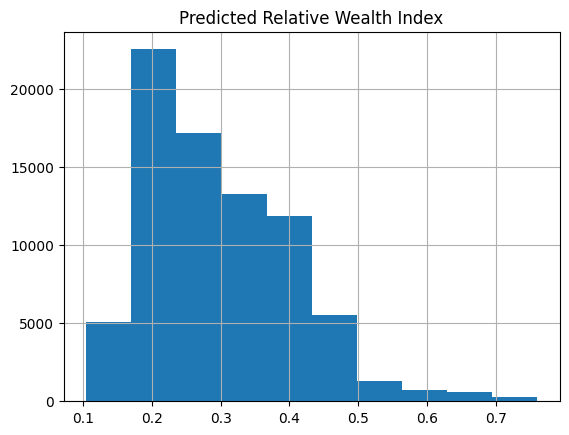

In [13]:
rollout_aoi[['Predicted Relative Wealth Index']].hist()

<Figure size 640x480 with 0 Axes>

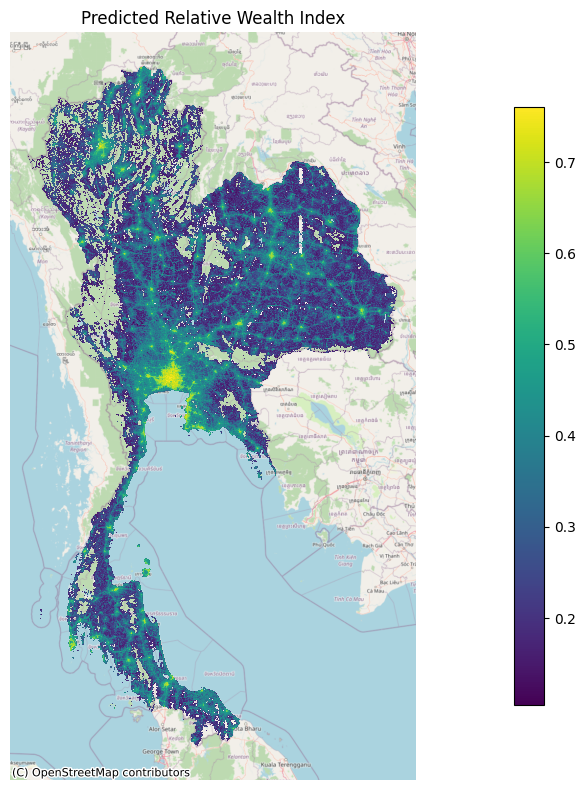

In [17]:
plt.cla()
plt.clf()
rollout_aoi_plot = rollout_aoi.to_crs("EPSG:3857")
ax = rollout_aoi_plot.plot("Predicted Relative Wealth Index", figsize=(20, 8), cmap="viridis", legend=True, legend_kwds={'shrink': 0.8})
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Predicted Relative Wealth Index")
plt.tight_layout()
plt.savefig(f'{rollout_date}-{country_code}-predicted-wealth-index.png')
plt.show()

In [15]:
rollout_aoi.head()

,quadkey,shapeName,shapeISO,shapeID,shapeGroup,shapeType,pop_count,geometry,Predicted Relative Wealth Index
0,13222121311300,Mueang Phuket,None,THA-ADM2-3_0_0-B565,THA,ADM2,755.127425,"POLYGON ((98.34961 7.60211, 98.34961 7.62389, ...",0.370390
1,13222121311301,Mueang Phuket,None,THA-ADM2-3_0_0-B565,THA,ADM2,449.253025,"POLYGON ((98.37158 7.60211, 98.37158 7.62389, ...",0.369976
2,13222121311303,Mueang Phuket,None,THA-ADM2-3_0_0-B565,THA,ADM2,19.117150,"POLYGON ((98.37158 7.58033, 98.37158 7.60211, ...",0.319220
3,13222121133321,Mueang Phuket,None,THA-ADM2-3_0_0-B565,THA,ADM2,305.874400,"POLYGON ((98.37158 7.73277, 98.37158 7.75454, ...",0.298018
4,13222121133213,Mueang Phuket,None,THA-ADM2-3_0_0-B565,THA,ADM2,305.874400,"POLYGON ((98.32764 7.75454, 98.32764 7.77631, ...",0.542874


In [14]:
rollout_aoi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 78254 entries, 0 to 78253
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   quadkey                          78254 non-null  object  
 1   shapeName                        78254 non-null  object  
 2   shapeISO                         78254 non-null  object  
 3   shapeID                          78254 non-null  object  
 4   shapeGroup                       78254 non-null  object  
 5   shapeType                        78254 non-null  object  
 6   pop_count                        78254 non-null  float64 
 7   geometry                         78254 non-null  geometry
 8   Predicted Relative Wealth Index  78254 non-null  float64 
dtypes: float64(2), geometry(1), object(6)
memory usage: 5.4+ MB


## Binning predictions into wealth categories

Afterwards, we label the predicted relative wealth by binning them into 5 categories 

|Category |Description| 
|---|-----------------| 
| A | high income | 
| B | mid-high income | 
| C | middle income | 
| D | mid-low income | 
| E | low income |

We can create these wealth categories by splitting the output `Predicted Relative Wealth Index` distribution into 5 equally sized **quintiles**, i.e. every 20th percentile.

### Calculate quintile wealth category

In [18]:
rollout_aoi["Predicted Wealth Category (quintile)"] = categorize_wealth_index(
    rollout_aoi["Predicted Relative Wealth Index"], 
).astype(str)


<Figure size 640x480 with 0 Axes>

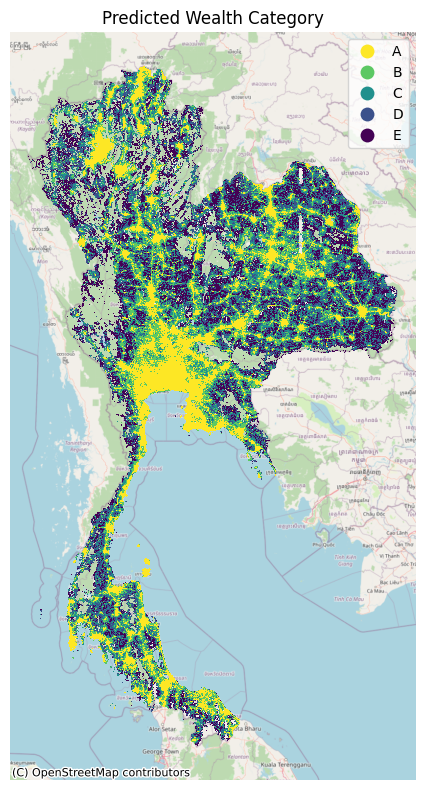

In [19]:
plt.cla()
plt.clf()
rollout_aoi_plot = rollout_aoi.to_crs("EPSG:3857")
ax = rollout_aoi_plot.plot("Predicted Wealth Category (quintile)", figsize=(20, 8), cmap="viridis_r", legend=True)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Predicted Wealth Category")
plt.tight_layout()
plt.savefig(f'{rollout_date}-{country_code}-predicted-wealth-bin.png')
plt.show()

In [ ]:
cols_of_interest = [
    "quadkey",
    "shapeName",
    "shapeGroup",
    "pop_count",
    "avg_rad_mean",
    "mobile_2019_mean_avg_d_kbps_mean",
    "fixed_2019_mean_avg_d_kbps_mean",
    "poi_count",
    "road_count",
    "Predicted Relative Wealth Index",
    "Predicted Wealth Category (quintile)",
]

# Warning: This can be a bit laggy due to the large amount of tiles being visualized

# Uncomment the ff if you want to viz the raw wealth predictions
# rollout_aoi.explore(column='Predicted Relative Wealth Index', tooltip=cols_of_interest, cmap="viridis")

# Uncomment the ff if you want to view the quintiles
# rollout_aoi.explore(column='Predicted Wealth Category (quintile)', tooltip=cols_of_interest, cmap="viridis_r")

## Save output

In [ ]:
%%time
rollout_aoi.to_file(f'{rollout_date}-{country_code}-rollout-output.geojson', driver='GeoJSON', index=False)

CPU times: user 28.3 s, sys: 781 ms, total: 29.1 s
Wall time: 32.2 s
